Get various imports and helper functions
The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [2]:
import torch
from torch import nn
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves


In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
# Setup the device

device = "cuda" if torch.cuda.is_available() else "cpu"
device
     

'cuda'

### 0. Get the data
Get data
Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

#### Preprocess data turn images into tensors
Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms, # use manually created transforms
    test_transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x127cc40b430>,
 ['pizza', 'steak', 'sushi'])

#### Visulaize a single image here


In [11]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

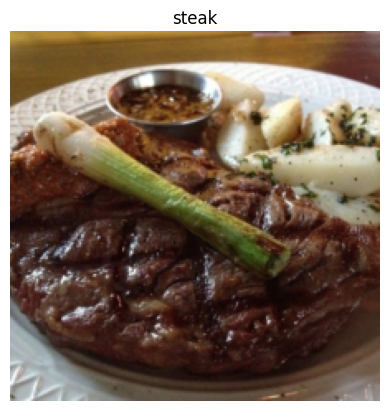

In [12]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

### 1. Replicate the ViT architecture we created with in-built PyTorch transformer layers.
You'll want to look into replacing our TransformerEncoderBlock() class with torch.nn.TransformerEncoderLayer() (these contain the same layers as our custom blocks).
You can stack torch.nn.TransformerEncoderLayer()'s on top of each other with torch.nn.TransformerEncoder().
- Need:
1. PatchEmbedding (turn images into embedded patches)
2. Transformer Encoder layer (this is comprised of alternating MSA and MLP blocks)
3. Stack multiple transformer encoder layers on top of each other
4. MLP head
5. Put it all together to create ViT

#### 1. Make Patch Embedding Layer
Code from: https://www.learnpytorch.io/08_pytorch_paper_replicating/#45-turning-the-vit-patch-embedding-layer-into-a-pytorch-module

In [13]:
rand_image_tensor = torch.randn(32, 3, 224, 224) # (batch_size, color_channels, height, width)
rand_image_tensor.shape

torch.Size([32, 3, 224, 224])

In [18]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        print(f"Shape after patcher layer: {x_patched.shape}")
        x_flattened = self.flatten(x_patched)
        print(f"Shape after flatten layer: {x_flattened.shape}")
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [19]:
patch_embedding = PatchEmbedding(patch_size=16)
patch_embedding_output = patch_embedding(rand_image_tensor)
print(f"Input shape: {rand_image_tensor.shape}")
print(f"Output shape: {patch_embedding_output.shape} -> (batch_size, num_patches, embedding_dim)") 

Shape after patcher layer: torch.Size([32, 768, 14, 14])
Shape after flatten layer: torch.Size([32, 768, 196])
Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 196, 768]) -> (batch_size, num_patches, embedding_dim)


#### 2. Transformer Encoder Layer
Can build a Transformer Encoder Layer with: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer

In [22]:
# Hyperparameters from Table 1 and Table 3 for ViT-Base
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation="gelu", # non-linear transformation
                                                       batch_first=True,
                                                       norm_first=True)
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [24]:
# Looking at the layer summary
summary(model=transformer_encoder_layer,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [32, 196, 768]            7,087,872
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 19.27
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 19.27

### 3. Stack Transformer Encoder Layers on top of each other to make the full Transformer Encoder
- According to Table 1 of the ViT paper, the ViT-Base model uses a stack of 12 Transformer Encoder layers.

- We can stack Transformer Encoder Layers on top of each other using: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder

In [25]:
# usign the encoder to stach encoderlayer over each other
transformer_encoder = nn.TransformerEncoder(
    encoder_layer=transformer_encoder_layer,
    num_layers=12)

transformer_encoder

c:\Users\PC\Documents\Pytorch_models\myenv\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

In [26]:
summary(model=transformer_encoder,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoder                       [32, 196, 768]            --
├─ModuleList: 1-1                        --                        --
│    └─TransformerEncoderLayer: 2-1      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-2      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-3      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-4      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-5      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-6      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-7      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-8      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-9      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-10     [32, 196, 768]            7,087,872
│    └─Transfor

### 5. Put it all together and create ViT
We're skipping step 4, so that can be incorported the into the overall ViT architecture.

In [62]:
class ViT(nn.Module):
    def __init__(self,
                 img_size: int=224,
                 num_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768,
                 dropout: float=0.1,
                 mlp_size: int=3072,
                 num_transformer_layers: int=12,
                 num_heads: int=12,
                 num_classes: int=1000):
        super().__init__()

        # Assert image size is divisible by patch size
        assert img_size % patch_size == 0, "Image size should be divisible by patch size"

        # 1. Create patch embeddings on the image
        self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        # 2. Create a class token
        self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim, requires_grad=True))
        
        # 3. Create positional embedding
        num_patches = (img_size*img_size) // patch_size**2 # N = H*W / P^2
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1,
                                                             embedding_dim))

        # 4. Create patch + positional embedding droptout
        self.embedding_dropout = nn.Dropout(p=dropout)
        # 5. Create transformer encoding layers
        # self.transformer_encoder_layer = nn.TransformerEncoderLayer(
        #     d_model=embedding_dim,
        #     nhead=num_heads,
        #     dim_feedforward=mlp_size,
        #     activation="gelu",
        #     batch_first=True,
        #     norm_first=True
        # )
        # 6. Create a stack of transformer enoder
        self.transformer_encoder = nn.TransformerEncoder(
                                                            encoder_layer=nn.TransformerEncoderLayer(
                                                            d_model=embedding_dim,
                                                            nhead=num_heads,
                                                            dim_feedforward=mlp_size,
                                                            activation="gelu",
                                                            batch_first=True,
                                                            norm_first=True
                                                        ),
            num_layers=num_transformer_layers
        )
        # 7. Create MLP head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # forward method to connect all the layers above
    def forward(self,x):
        # get some dimension from x
        batch_size = x.shape[0] # [B,C,H,W]

        # Create the patch embedding
        x = self.patch_embedding(x)
        print(x.shape)
        
        # First expand the class token across the batch size
        class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

        # Prepend the class token to the patch embedding
        x = torch.cat((class_token, x), dim=1)
        # print("in vit: ",x.shape)

        # Add th positional embedding to patch embedding with class token
        x = self.positional_embedding + x
        print(x.shape)

        # dropout on patch + positional embedding
        x = self.embedding_dropout(x)

        # Pass embedding through Transformer Encoder stack
        x = self.transformer_encoder(x)

        # Pass 0th index of xthrough MLP head
        x = self.mlp_head(x[:,0])

        return x


In [63]:
# Testing the class_token part
demo_img = torch.randn(1,3,224,224).to(device)
print(demo_img.shape)
vit = ViT(num_classes=len(class_names)).to(device)
vit(demo_img)

torch.Size([1, 3, 224, 224])
Shape after patcher layer: torch.Size([1, 768, 14, 14])
Shape after flatten layer: torch.Size([1, 768, 196])
torch.Size([1, 196, 768])
torch.Size([1, 197, 768])


tensor([[ 0.3615, -0.1677, -0.4223]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [9]:
# Testing the position embedding code
patch_size = 16
img_size = 224
embedding_dim = 768
num_patches = (img_size*img_size) // patch_size**2
pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))
pos_embedding.shape

torch.Size([1, 197, 768])

In [64]:
# Get the summary of our model
summary(model=ViT(num_classes=len(class_names)),
        input_size=demo_img.shape)

Shape after patcher layer: torch.Size([1, 768, 14, 14])
Shape after flatten layer: torch.Size([1, 768, 196])
torch.Size([1, 196, 768])
torch.Size([1, 197, 768])


Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

### 2. Turn the custom ViT architecture we created into a Python script, for example, vit.py.
- You should be able to import an entire ViT model using something likefrom vit import ViT.
- Let's copy all of our ViT model dependencies to a single cell and write it to file using the magic %writefile FILENAME.

In [67]:
%%writefile going_modular/vit.py
import torch
from torch import nn


# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        #print(f"Shape after patcher layer: {x_patched.shape}")
        x_flattened = self.flatten(x_patched)
        #print(f"Shape after flatten layer: {x_flattened.shape}")
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


class ViT(nn.Module):
    def __init__(self,
                 img_size: int=224,
                 num_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768,
                 dropout: float=0.1,
                 mlp_size: int=3072,
                 num_transformer_layers: int=12,
                 num_heads: int=12,
                 num_classes: int=1000):
        super().__init__()

        # Assert image size is divisible by patch size
        assert img_size % patch_size == 0, "Image size should be divisible by patch size"

        # 1. Create patch embeddings on the image
        self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        # 2. Create a class token
        self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim, requires_grad=True))
        
        # 3. Create positional embedding
        num_patches = (img_size*img_size) // patch_size**2 # N = H*W / P^2
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1,
                                                             embedding_dim))

        # 4. Create patch + positional embedding droptout
        self.embedding_dropout = nn.Dropout(p=dropout)
        # 5. Create transformer encoding layers
        # self.transformer_encoder_layer = nn.TransformerEncoderLayer(
        #     d_model=embedding_dim,
        #     nhead=num_heads,
        #     dim_feedforward=mlp_size,
        #     activation="gelu",
        #     batch_first=True,
        #     norm_first=True
        # )
        # 6. Create a stack of transformer enoder
        self.transformer_encoder = nn.TransformerEncoder(
                                                            encoder_layer=nn.TransformerEncoderLayer(
                                                            d_model=embedding_dim,
                                                            nhead=num_heads,
                                                            dim_feedforward=mlp_size,
                                                            activation="gelu",
                                                            batch_first=True,
                                                            norm_first=True
                                                        ),
            num_layers=num_transformer_layers
        )
        # 7. Create MLP head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # forward method to connect all the layers above
    def forward(self,x):
        # get some dimension from x
        batch_size = x.shape[0] # [B,C,H,W]

        # Create the patch embedding
        x = self.patch_embedding(x)
        #print(x.shape)
        
        # First expand the class token across the batch size
        class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

        # Prepend the class token to the patch embedding
        x = torch.cat((class_token, x), dim=1)
        # print("in vit: ",x.shape)

        # Add th positional embedding to patch embedding with class token
        x = self.positional_embedding + x
        #print(x.shape)

        # dropout on patch + positional embedding
        x = self.embedding_dropout(x)

        # Pass embedding through Transformer Encoder stack
        x = self.transformer_encoder(x)

        # Pass 0th index of xthrough MLP head
        x = self.mlp_head(x[:,0])

        return x


Overwriting going_modular/vit.py


In [68]:
from going_modular.vit import ViT

imported_vit = ViT()
summary(model=imported_vit,
        input_size=(1,3,224,224))

Shape after patcher layer: torch.Size([1, 768, 14, 14])
Shape after flatten layer: torch.Size([1, 768, 196])
torch.Size([1, 196, 768])
torch.Size([1, 197, 768])


Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

### 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10) on 20% of the pizza](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset), steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
- See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6.](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size)

In [19]:
# Create ViT feature extractor model
import torchvision
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # 'DEfault means best available
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights).to(device)
pretrained_vit

# Freeze all layers in pretrained model
for param in pretrained_vit.parameters():
    param.requires_grad = False

# update the pretrained vit to out needs head
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

# Print a summary
summary(model=pretrained_vit, 
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [20]:
# Get 20% data
# Get 20% of the data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train and test directories
train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test" # don't need 20% test data as the model in 07. PyTorch Experiment Tracking section 7.3 tests on the 10% dataset not the 20%

# Preprocess the data
vit_transforms = vit_weights.transforms() # get transforms from vit_weights

# Create dataloaders from the dataset
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent, 
                                        test_dir=test_dir, # use 10% data for testing
                                        train_transform=vit_transforms,
                                        test_transform=vit_transforms, 
                                        batch_size=32)


[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


In [21]:
len(train_dataloader_20_percent),len(test_dataloader)

(15, 3)

In [22]:
# Train a pretrained ViT feature extractor
from going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
    train_dataloader=train_dataloader_20_percent,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6480 | train_acc: 0.7646 | test_loss: 0.2090 | test_acc: 0.9583
Epoch: 2 | train_loss: 0.2043 | train_acc: 0.9104 | test_loss: 0.1783 | test_acc: 0.9583
Epoch: 3 | train_loss: 0.1346 | train_acc: 0.9604 | test_loss: 0.1657 | test_acc: 0.9583
Epoch: 4 | train_loss: 0.1009 | train_acc: 0.9625 | test_loss: 0.1588 | test_acc: 0.9583
Epoch: 5 | train_loss: 0.0881 | train_acc: 0.9750 | test_loss: 0.1633 | test_acc: 0.9583
Epoch: 6 | train_loss: 0.0984 | train_acc: 0.9521 | test_loss: 0.1656 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.0692 | train_acc: 0.9792 | test_loss: 0.1783 | test_acc: 0.9479
Epoch: 8 | train_loss: 0.0593 | train_acc: 0.9938 | test_loss: 0.1846 | test_acc: 0.9688
Epoch: 9 | train_loss: 0.0591 | train_acc: 0.9938 | test_loss: 0.1892 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0412 | train_acc: 0.9938 | test_loss: 0.1852 | test_acc: 0.9583


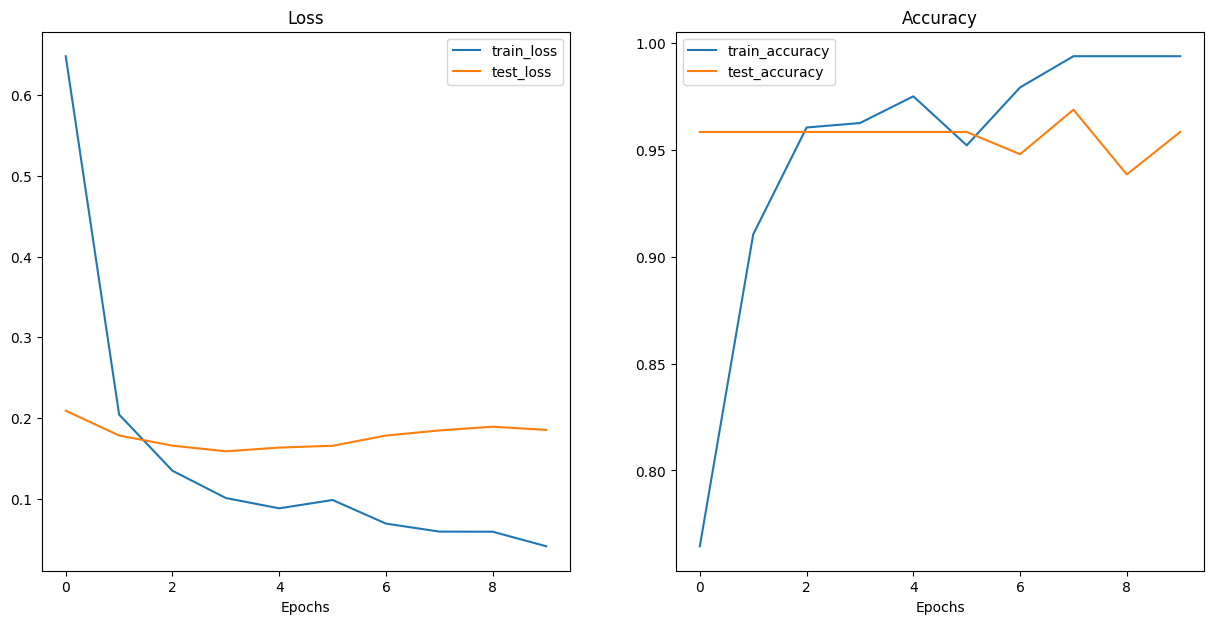

In [23]:
# Examine results
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 4. Try repeating the steps from excercise 3 but this time use the "ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1" pretrained weights from torchvision.models.vit_b_16().
- Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [26]:
# Create ViT feature extractor model

# Download pretrained ViT weights and model
vit_weights_swag = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 # get SWAG weights
pretrained_vit_swag = torchvision.models.vit_b_16(weights=vit_weights_swag).to(device)

# Freeze all layers in pretrained ViT model 
for param in pretrained_vit_swag.parameters():
  param.requires_grad = False

# Update the preatrained ViT head 
embedding_dim = 768 # ViT_Base
set_seeds()
pretrained_vit_swag.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim, 
              out_features=len(class_names))
)

# Print a summary
summary(model=pretrained_vit_swag, 
        input_size=(1, 3, 384, 384), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     (590,592)            False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 5

In [25]:
# Get 20% data
# Get 20% of the data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train and test directories
train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test" # don't need 20% test data as the model in 07. PyTorch Experiment Tracking section 7.3 tests on the 10% dataset not the 20%

# Preprocess the data
vit_transforms_swag = vit_weights_swag.transforms() # get transforms from vit_weights

# Create dataloaders from the dataset
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent, 
                                        test_dir=test_dir, # use 10% data for testing
                                        train_transform=vit_transforms_swag,
                                        test_transform=vit_transforms_swag, 
                                        batch_size=32)

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


In [27]:
# Train a pretrained ViT feature extractor with SWAG weights
from going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit_swag.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_swag_results = engine.train(model=pretrained_vit_swag,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4661 | train_acc: 0.9000 | test_loss: 0.0779 | test_acc: 0.9792
Epoch: 2 | train_loss: 0.0641 | train_acc: 0.9854 | test_loss: 0.0619 | test_acc: 0.9896
Epoch: 3 | train_loss: 0.0407 | train_acc: 0.9875 | test_loss: 0.0488 | test_acc: 0.9896
Epoch: 4 | train_loss: 0.0300 | train_acc: 0.9938 | test_loss: 0.0427 | test_acc: 0.9896
Epoch: 5 | train_loss: 0.0241 | train_acc: 0.9938 | test_loss: 0.0435 | test_acc: 0.9896
Epoch: 6 | train_loss: 0.0205 | train_acc: 0.9979 | test_loss: 0.0406 | test_acc: 0.9896
Epoch: 7 | train_loss: 0.0168 | train_acc: 0.9979 | test_loss: 0.0387 | test_acc: 0.9896
Epoch: 8 | train_loss: 0.0197 | train_acc: 0.9979 | test_loss: 0.0396 | test_acc: 0.9896
Epoch: 9 | train_loss: 0.0131 | train_acc: 1.0000 | test_loss: 0.0489 | test_acc: 0.9896
Epoch: 10 | train_loss: 0.0123 | train_acc: 0.9979 | test_loss: 0.0403 | test_acc: 0.9896


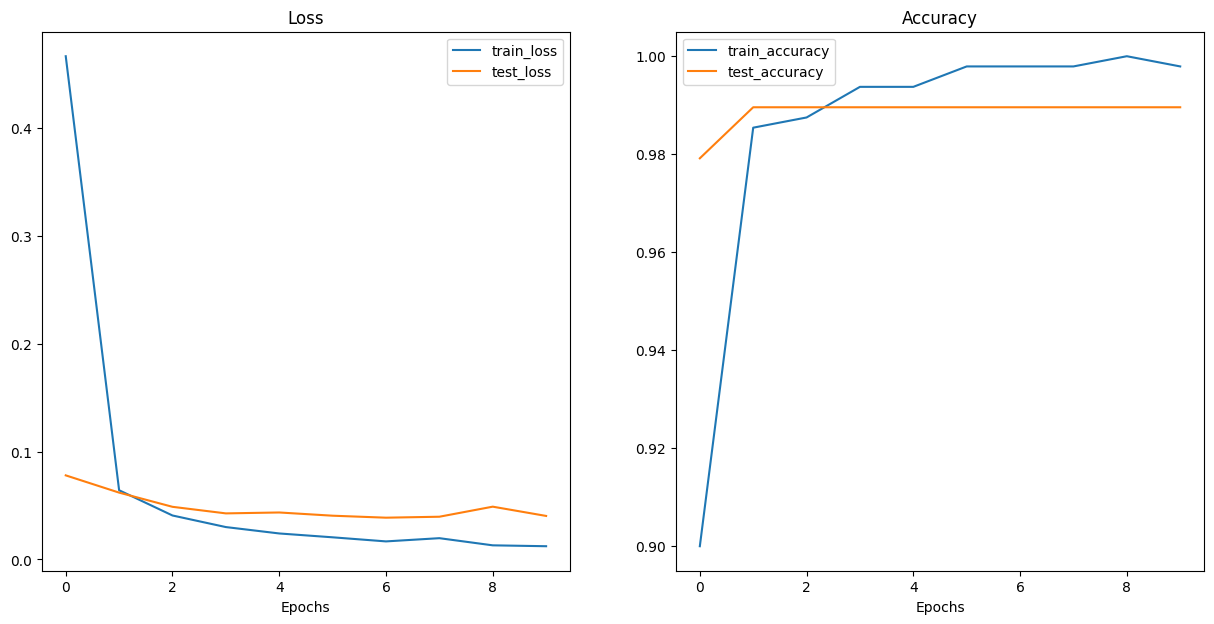

In [28]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_swag_results)

### Bonus: Get the "most wrong" examples from the test dataset
Since our ViT model trained with SWAG weights performed so well on the test set (close to 99% accuracy), let's see which samples it actually got wrong...

Code from: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb exercise 2

In [2]:
%%writefile going_modular/pred_and_store.py
# Get all test data paths
from PIL import Image
from tqdm import tqdm
from pathlib import Path
# test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
# test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  # if not test_paths:
  #   assert test_dir, "Please give a test_dir or test_paths"
  #   test_paths = list(Path(test_dir).glob("*/*.jpg"))
  # To recover the ckass names if any fro the dir
  #test_labels = [path.parent.stem for path in test_data_paths]
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    # from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU 
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class
  
    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list


Overwriting going_modular/pred_and_store.py


In [32]:

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=pretrained_vit_swag,
                                 transform=vit_transforms_swag,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

100%|██████████| 75/75 [00:02<00:00, 28.77it/s]


[{'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9995324611663818,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9997987151145935,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9999426603317261,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.999769389629364,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9996782541275024,
  'pred_class': 'pizza',
  'correct': True}]

In [33]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob 
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
12,data\pizza_steak_sushi\test\pizza\2508636.jpg,pizza,0.802987,steak,False
2,data\pizza_steak_sushi\test\pizza\1687143.jpg,pizza,0.999943,pizza,True
8,data\pizza_steak_sushi\test\pizza\2111981.jpg,pizza,0.999942,pizza,True
22,data\pizza_steak_sushi\test\pizza\714866.jpg,pizza,0.999933,pizza,True
31,data\pizza_steak_sushi\test\steak\1882831.jpg,steak,0.999922,steak,True


In [34]:
# How many samples from the test dataset did our model get correct?
test_pred_df.correct.value_counts()

correct
True     74
False     1
Name: count, dtype: int64

C:\Users\PC\AppData\Local\Temp\ipykernel_3480\1749797213.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[0]
C:\Users\PC\AppData\Local\Temp\ipykernel_3480\1749797213.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[1]
C:\Users\PC\AppData\Local\Temp\ipykernel_3480\1749797213.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_prob = row[2]
C:\Users\PC\AppData\Local\Temp\ipykernel_3480\1749

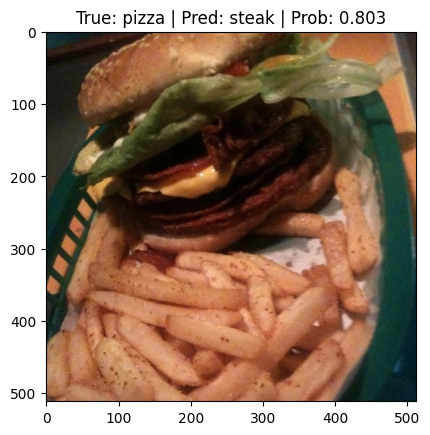

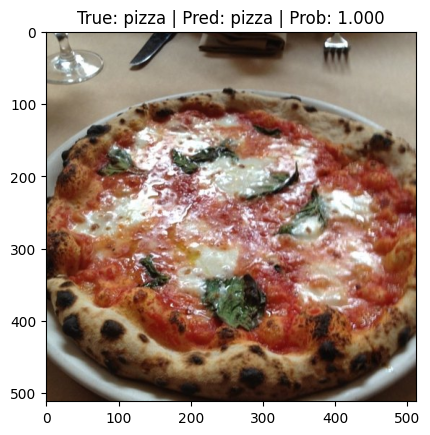

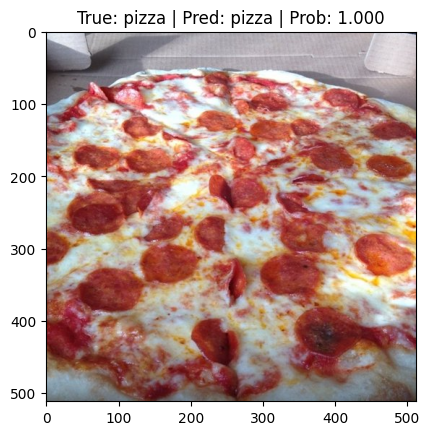

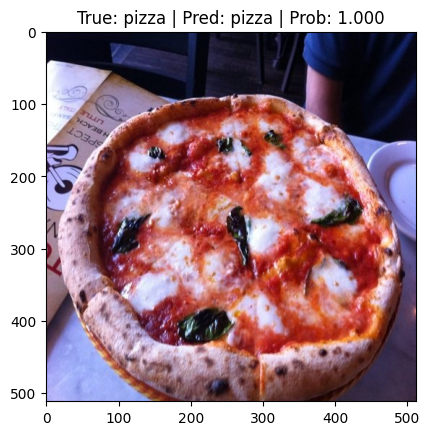

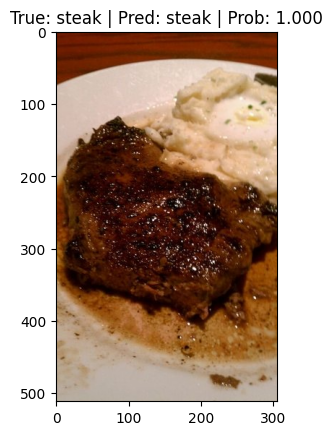

In [35]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")